# Linear Regression Implementation from Scratch


In this demo, we obtain a sample from a data generating process (dgp), and estimate it in three ways:
* SGD
* OLS equation manually
* OLS using sklearn machine learning package

In [47]:
import pylab as plt #for plots

import random
import torch

#for OLS using sklearn package
import pandas as pd           #Python Data Analysis Library handle data in a user friendly way
import numpy as np
from sklearn import linear_model # A very popular Python library for Machine Learning
from sklearn.linear_model import LinearRegression

#OLS manually
from numpy import matmul
from numpy.linalg import inv

#timer
import time

## Generating the dataset

- Randomly generate $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$ from the standard normal distribution.
- Parameters: weight $\mathbf{w} = [2, -3.4]^\top$ and bias $b = 4.2$
- Generate label by $\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$
  with noise $\epsilon\sim N(\mathbf{0},0.01^2\mathbf{I})$

In [48]:
#Function to generate data
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise.
        Return X and y"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b  #torch.mv does not broadcast so use matmul
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))


In [50]:
#Values for parameters and set sample size.
true_w = torch.tensor([2, -3.4])
true_b = 4.2
sampl_size=20

#call to synthetic_data to generate data
features, labels = synthetic_data(true_w, true_b, sampl_size)

In [51]:
a = (1,2)
print(type(a))
b,c = a
print(b)

<class 'tuple'>
1


In [52]:
print(type(features))
torch.is_tensor(features), torch.is_tensor(labels)

<class 'torch.Tensor'>


(True, True)

In [53]:
features.shape

torch.Size([20, 2])

In [54]:
#Have a look at the 1st 5 observation (features and label)
print('features:', features[0:4],'\nlabel:', labels[0:4])

features: tensor([[ 0.5454, -1.3423],
        [ 0.7647,  2.1852],
        [-0.3386,  0.3280],
        [ 1.2967, -0.7609]]) 
label: tensor([[ 9.8555],
        [-1.7152],
        [ 2.4177],
        [ 9.3610]])


## Visualising the relationship between the features and label.


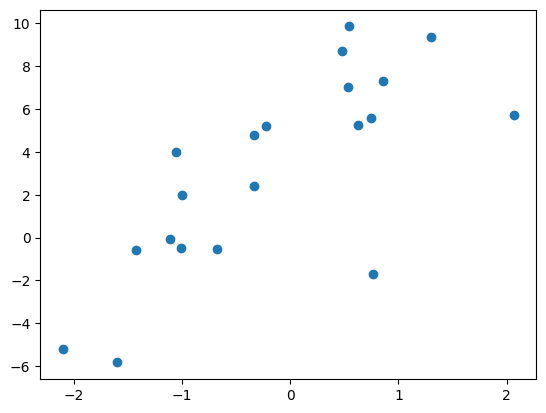

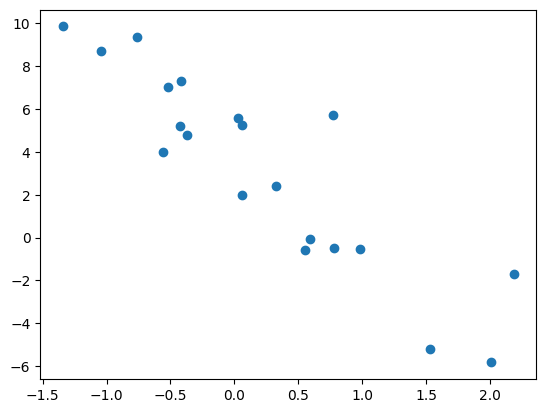

In [55]:
# Scatterplot of label against each feature.

#1st feature
plt.scatter(features[:,0],labels)
plt.show()

#2nd feature
plt.scatter(features[:,1],labels)
plt.show()

## Reading the Dataset

Iterate over the data set and return `batch_size` (batch size) random examples.

In [72]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [56]:
def know_yield(nums):
    for i in range(nums):
        yield i

In [57]:
test_yield = know_yield(10)

print(test_yield)

<generator object know_yield at 0x302b713c0>


In [58]:
test_yield

<generator object know_yield at 0x302b713c0>

In [69]:
next(test_yield)

StopIteration: 

### Activity 1

Study the function `a_generator`, below, in order to understand the `data_iter` function.

If you can't follow it, paste the code (both parts) into [Python Tutor](https://pythontutor.com/python-debugger.html#mode=edit). Observe then using yield, the function a_generator is run once only. When you call it the second time, it goes to the second yield line, the next and last time will go to the 3rd yield line.

In [70]:
#Break down of data_iter by studying something similar

def a_generator():
    # n = 9
    toy_data= ["a","b","c","d","e","f","g","h","i"]
    print(f"the data: {toy_data}")
    #Shuffled_indices permutes the indices 0 to 8, and arranges in mini-batches of 3
    shuffled_indices_1 = [8, 2, 6]
    shuffled_indices_2 = [4, 7, 3]
    shuffled_indices_3 = [0, 1, 5]
    #The 3 yield would be the output of the for loop in data_iter()
    yield [toy_data[i] for i in shuffled_indices_1]
    yield [toy_data[i] for i in shuffled_indices_2]
    yield [toy_data[i] for i in shuffled_indices_3]

In [71]:
test_generator = a_generator()
for j in test_generator:
    print(j)

the data: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
['i', 'c', 'g']
['e', 'h', 'd']
['a', 'b', 'f']


In [31]:
print(a_generator())

item = a_generator()
print(next(item))
print(next(item))
print(next(item))

next(item)


<generator object a_generator at 0x14da7a820>
the data: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
['i', 'c', 'g']
['e', 'h', 'd']
['a', 'b', 'f']


StopIteration: 

In [44]:
test_list = iter([1,2,3,4])
type(test_list)

list_iterator

In [46]:
next(test_list)

2

## Scatterplot of a mini-batch

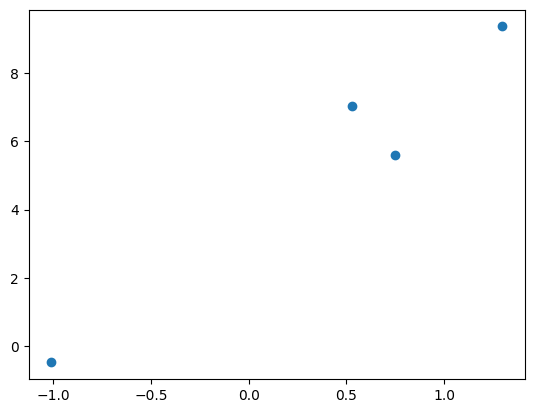

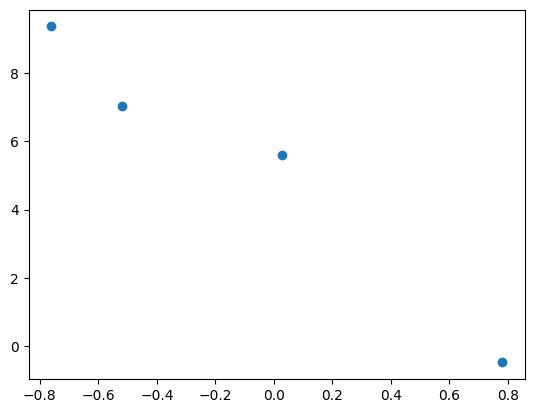

In [77]:
# Get a minbatch
batch_size = 4
a_minibatch = data_iter(batch_size, features, labels)
batch_features, batch_labels = next(a_minibatch) #next is used with yield.

#scatterplot

#1st feature
plt.scatter(batch_features[:,0],batch_labels)
plt.show()

#2nd feature
plt.scatter(batch_features[:,1],batch_labels)
plt.show()

# Each time you run this block of code you get a different scatterplot. Explain why.

In [78]:
#See all the minibatches
for j in a_minibatch:
    print(batch_features, batch_labels)
    print(batch_features.shape)
    print(batch_labels.shape)

tensor([[ 1.2967, -0.7609],
        [-1.0104,  0.7796],
        [ 0.5297, -0.5195],
        [ 0.7485,  0.0286]]) tensor([[ 9.3610],
        [-0.4781],
        [ 7.0367],
        [ 5.6034]])
torch.Size([4, 2])
torch.Size([4, 1])
tensor([[ 1.2967, -0.7609],
        [-1.0104,  0.7796],
        [ 0.5297, -0.5195],
        [ 0.7485,  0.0286]]) tensor([[ 9.3610],
        [-0.4781],
        [ 7.0367],
        [ 5.6034]])
torch.Size([4, 2])
torch.Size([4, 1])
tensor([[ 1.2967, -0.7609],
        [-1.0104,  0.7796],
        [ 0.5297, -0.5195],
        [ 0.7485,  0.0286]]) tensor([[ 9.3610],
        [-0.4781],
        [ 7.0367],
        [ 5.6034]])
torch.Size([4, 2])
torch.Size([4, 1])
tensor([[ 1.2967, -0.7609],
        [-1.0104,  0.7796],
        [ 0.5297, -0.5195],
        [ 0.7485,  0.0286]]) tensor([[ 9.3610],
        [-0.4781],
        [ 7.0367],
        [ 5.6034]])
torch.Size([4, 2])
torch.Size([4, 1])


## 1. Parameter estimation using SGD


### Initialize model parameters

Here we specify that

-  each weight parameter is randomly sampled from a normal distribution with mean 0 and standard deviation 0.01.
-  The bias parameter will be initialized to zero.

This is a pretty non-sophisticated way to do it, and we will discuss better ways.


In [79]:
#intialise parameters
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### Define the model

In [82]:
def linreg(X, w, b):
    """The linear regression model.Return Xw+b"""
    return torch.matmul(X, w) + b

### Define the Loss Function

In [81]:
def squared_loss(y_hat, y):
    """Return squared loss/2"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### Defining the Optimization Algorithm SGD

In [ ]:
a -= b
# equavalent to
a = a - b

In [80]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:

            #update all parameters
            param -= lr * param.grad / batch_size

             # zero the gradients before running the backward pass.
            param.grad.zero_()

### Training

For minibatch SGD, we execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In [83]:
#hyperparameters
batch_size = 50
lr = 0.8
num_epochs = 20

#Model specification
net = linreg
loss = squared_loss

print(net)
print(linreg)

<function linreg at 0x302c72dc0>
<function linreg at 0x302c72dc0>


# Training

In [84]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        tic = time.perf_counter()

        #compute the loss with forward pass net() to get predictions
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`

        # backward pass to compute gradient on `l` with respect to
        #learnable parameters [`w`, `b`]
        l.sum().backward()

        # call to sgd function that uppdates parameters using SGD
        sgd([w, b], lr, batch_size)

    with torch.no_grad():
        yhat = net(features, w, b)
        train_l = loss(yhat, labels)
        toc = time.perf_counter()
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}, time for one epoch {toc - tic:0.4f} seconds')

epoch 1, loss 7.243015, time for one epoch 0.1294 seconds
epoch 2, loss 3.714826, time for one epoch 0.0010 seconds
epoch 3, loss 1.977414, time for one epoch 0.0001 seconds
epoch 4, loss 1.081285, time for one epoch 0.0001 seconds
epoch 5, loss 0.604524, time for one epoch 0.0001 seconds
epoch 6, loss 0.344824, time for one epoch 0.0001 seconds
epoch 7, loss 0.200436, time for one epoch 0.0001 seconds
epoch 8, loss 0.118600, time for one epoch 0.0001 seconds
epoch 9, loss 0.071345, time for one epoch 0.0001 seconds
epoch 10, loss 0.043567, time for one epoch 0.0001 seconds
epoch 11, loss 0.026961, time for one epoch 0.0001 seconds
epoch 12, loss 0.016879, time for one epoch 0.0001 seconds
epoch 13, loss 0.010673, time for one epoch 0.0001 seconds
epoch 14, loss 0.006808, time for one epoch 0.0001 seconds
epoch 15, loss 0.004375, time for one epoch 0.0001 seconds
epoch 16, loss 0.002832, time for one epoch 0.0001 seconds
epoch 17, loss 0.001846, time for one epoch 0.0001 seconds
epoch 

In [86]:
# Compare true values to estimates
print(b, true_b)
print(w, true_w)

tensor([4.1870], requires_grad=True) 4.2
tensor([[ 2.0167],
        [-3.3688]], requires_grad=True) tensor([ 2.0000, -3.4000])


## 2. Compute OLS manually

In [25]:
# create the design matrix: the x data, and add a column of ones for the constant term
X = np.column_stack( [np.ones([len(features), 1]), features.reshape(-1, 2)] )

# These are the normal equations in matrix form: b_hat = (X' X)^-1 X' y
b_hat = matmul(inv(matmul(X.transpose(),X)),X.transpose()).dot(labels)
print(b_hat)

[[ 4.20259781]
 [ 1.99701012]
 [-3.39717185]]


# 3. OLS using sklearn package

In [26]:
# This block is optional
#Compare to OLS
data = pd.DataFrame(np.column_stack([features,labels]),columns=['x1','x2','y']) #columns, then column names
data[0:4]

predictors = ['x1','x2']
linreg = LinearRegression(fit_intercept=True)
linreg.fit(data[predictors],data['y'])
y_pred = linreg.predict(data[predictors])

#Display OLS estimates
mse = np.mean((y_pred-data['y'])**2)/2
results = [mse]
results.extend([linreg.intercept_])
results.extend(linreg.coef_)
results = pd.DataFrame([results],columns = ['mse','bias','w1','w2'])
results

,mse,bias,w1,w2
0,0.000051,4.202598,1.99701,-3.397171


### Activity 2

Things to try:
1. (Compulsory) Let's see the effect of changing the learning rate on the shape of the loss over epochs for different orders of magnitude of the learning rate, keeping all other hyperparameters constant.
    1. Re-run the training on the same simulated data for learning rates: 0.01, 0.9, 10, 15. In this case, which learning rate is best? Are the results as you expect? (Here you should notice the performance is sensitive to the learning rate. Generally learning performance is sensitive to hyperparameters. )
    1. Train the model with the learning rate set to the negative of the optimal learning rate found in part A. What do you observe? Can you explain it?

1. Repeat the demo but simulate data from a model with 3 instead of 2 features.
1. Does the convergence of SGD depend on the initial values? Try a few initialisations like setting them all to 0.
1. In the `sgd` function, if you remove `with torch.no_grad():` does the program still run? If it does, is there a noticeable change in the time to run through an epoch?
1. If the number of examples cannot be divided by the batch size, what happens to the `data_iter` function's behavior?
1. Add regression outliers and see how close your estimates are to the true parameters.

[Discussions](https://discuss.d2l.ai/t/43)
